# Colab Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/radistoubalidis/JSRepair.git

!pip install pytorch_lightning
!python -m pip install lightning
!pip install datasets
!pip install python-dotenv
!pip install rouge-score

In [ ]:
%cd ./JSRepair

# Training

In [1]:
from transformers import (
    RobertaTokenizer,
)
from modules.models import CodeT5
from modules.datasets import CodeT5Dataset
from modules.TrainConfig import init_logger, init_checkpoint, Trainer
from modules.filters import add_labels
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pytorch_lightning import Trainer as plTrainer
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import sqlite3
import torch
import numpy as np

In [2]:
HF_DIR = 'Salesforce/codet5-large'
TOKENIZER_MAX_LENGTH = 1024 #int(input('Tokenizer Max length: '))
DB_PATH = 'commitpack-datasets.db' if os.path.exists('commitpack-datasets.db') else '/content/drive/MyDrive/Thesis/commitpack-datasets.db'
DB_TABLE = 'commitpackft_classified_train'
if not os.path.exists(DB_PATH):
    raise RuntimeError('sqlite3 path doesnt exist.')
VAL_SIZE = 0.3
LOG_PATH = 'logs' if os.path.exists('logs') else '/content/drive/MyDrive/Thesis/logs'
VERSION = int(input('Training version: '))
LOAD_FROM_CPKT = input("Load from existing model (type cpkt path if true): ")
DEBUG = True if int(input('Debug Run (1,0): ')) == 1 else False
BATCH_SIZE = 2 if DEBUG is True else 32
CPKT_PATH = 'checkpoints' if os.path.exists('checkpoints') else '/content/drive/MyDrive/Thesis/checkpoints'
DROPOUT_RATE = float(input('Type dropout rate for classifier: '))
WITH_MOBILE = True if int(input('Consider mobile class (1,0): ')) == 1 else False
WITH_LAYER_NORM = True
WITH_ACTIVATION = True

if WITH_MOBILE:
    classLabels = {
        "mobile" : 0.,
        "functionality" : 0.,
        "ui-ux" : 0.,
        "compatibility-performance" : 0.,
        "network-security" : 0.,
        "general": 0.
    }
else:
    classLabels = {
        "functionality" : 0.,
        "ui-ux" : 0.,
        "compatibility-performance" : 0.,
        "network-security" : 0.,
        "general": 0.
    }

num_classes = len(classLabels.keys())
modelSize = HF_DIR.split('-')[-1]
MODEL_DIR = f"CodeT5_{modelSize}_JS_{num_classes}classes_{TOKENIZER_MAX_LENGTH}MaxL"
con = sqlite3.connect(DB_PATH)

## Types of Bugs distribution in samples

In [3]:
with open('bug-type-dist-query_train.sql', 'r') as f:
    query = f.read()

info_df = pd.read_sql_query(query, con)
info_df

,count(*),bug_type
0,90,mobile
1,2862,general
2,3147,ui-ux
3,3159,network-security
4,4396,compatibility-performance
5,4532,functionality


## Create Classification Labels

```json
{
    "mobile" : 0,
    "functionality" : 0,
    "ui-ux" : 0,
    "compatibility-performance" : 0,
    "network-security" : 0,
    "general": 0
}

Ένα δείγμα που κατηγοριοποιήθηκε ως σφάλμα λειτουργικότητας(functionality) και ui-ux θα έχει διάνυσμα ταξινόμησης ->
[0,1,1,0,0,0]
```


In [4]:
tokenizer = RobertaTokenizer.from_pretrained(HF_DIR)


def load_ds() -> pd.DataFrame:
    query = f"select * from {DB_TABLE}"
    ds_df = pd.read_sql_query(query, con)
    return ds_df

ds_df = load_ds()

ds_df['class_labels'] = ds_df['bug_type'].apply(lambda bT: add_labels(bT.split(','), classLabels))
if DEBUG:
    ds_df = ds_df.iloc[:10]

if not WITH_MOBILE:
    ds_df = ds_df[ds_df['bug_type'] != 'mobile']

ds_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels
0,14193,225ae89c984227f9c2cfbe0278618758256e577f,server.js,server.js,\n/**\n * @description a string as a paramete...,var express = require('express')\nvar strftime...,Add example code to test Heroku error app not ...,Add example code to test Heroku error app not ...,JavaScript,mit,"kiwi-lifter/timestamp-api,kiwi-lifter/timestam...",add exampl code test heroku error app load,1,"functionality,compatibility-performance","[1.0, 0.0, 1.0, 0.0, 0.0]"
1,17090,e9286911fcaa253b094eea4b532f07c31e9f3ee5,packages/plugins/sentry/server/middlewares/sen...,packages/plugins/sentry/server/middlewares/sen...,'use strict';\n\n/**\n * Programmatic sentry m...,'use strict';\n\n/**\n * Programmatic sentry m...,Fix calling sendError on wrong object,Fix calling sendError on wrong object\n\nFixes...,JavaScript,mit,"wistityhq/strapi,wistityhq/strapi",fix call senderror wrong object fix sentri plu...,1,"mobile,functionality,compatibility-performance","[1.0, 0.0, 1.0, 0.0, 0.0]"
2,3401,8b512427144c1a8ff55c149267708fd783754405,app/components/wallet/backup-recovery/WalletRe...,app/components/wallet/backup-recovery/WalletRe...,"// @flow\nimport React, { Component, PropTypes...","// @flow\nimport React, { Component, PropTypes...",Fix proptype checking in wallet recovery instr...,Fix proptype checking in wallet recovery instr...,JavaScript,apache-2.0,"input-output-hk/daedalus,input-output-hk/daeda...",fix proptyp check wallet recoveri instruct compon,1,functionality,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,33381,1ea806751405a7bfd7bf388eeabce2de0ad5c50f,templates:array.js,templates:array.js,ReactiveArray;\n\nthis.ReactiveArray = Reactiv...,ReactiveArray;\n\nthis.ReactiveArray = Reactiv...,Fix set function with underscore isEqual,Fix set function with underscore isEqual,JavaScript,mit,meteortemplates/array,fix set function underscor isequ,1,functionality,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,33412,5551c176fc2c5fa59de1fbd29f36a4b2538ae85e,bin/mai-chai-init.js,bin/mai-chai-init.js,'use strict';\n/* global require */\n/* global...,'use strict';\n/* global require */\n/* global...,Fix regex for win32 platform,Fix regex for win32 platform\n,JavaScript,mit,epsitec-sa/mai-chai,fix regex win32 platform,1,"ui-ux,compatibility-performance","[0.0, 1.0, 1.0, 0.0, 0.0]"


In [5]:
old_codes = ds_df[['message', 'old_contents', 'class_labels']]
old_codes['input_seq'] = old_codes['message'] + ' ' + tokenizer.sep_token + ' ' + old_codes['old_contents']
new_codes = ds_df[['message', 'new_contents', 'class_labels']]

TRAIN_old, VAL_old, TRAIN_new, VAL_new = train_test_split(old_codes, new_codes, test_size=VAL_SIZE, random_state=42)

print(f"Total training samples: {len(ds_df)}")

Total training samples: 10


/tmp/ipykernel_11908/355405387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_codes['input_seq'] = old_codes['message'] + ' ' + tokenizer.sep_token + ' ' + old_codes['old_contents']


### Dataset

In [6]:
TRAIN_encodings = tokenizer(
    TRAIN_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

VAL_encodings = tokenizer(
    VAL_old['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

TRAIN_decodings = tokenizer(
    TRAIN_new['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

VAL_decodings = tokenizer(
    VAL_new['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    pad_to_max_length=True,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

### Convert Class Labels into tensors

In [7]:
TRAIN_classes = torch.tensor(TRAIN_old['class_labels'].tolist())
VAL_classes = torch.tensor(VAL_old['class_labels'].tolist())
TRAIN_classes

tensor([[1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

#### Compute class weights
$pos\ weight[i] = (Number\ of\ negative\ samples\ for\ class\ i) / (Number\ of\ positive\ samples\ for\ class\ i)$

In [8]:
num_samples = TRAIN_classes.size(0)
num_classes = TRAIN_classes.size(1)

pos_counts = torch.sum(TRAIN_classes, dim=0)
neg_counts = num_samples - pos_counts
class_weights = neg_counts / (pos_counts + 1e-6)
class_weights = class_weights.numpy()

## Initialize Training Settings

In [9]:
logger = init_logger(log_path=LOG_PATH, model_dir=MODEL_DIR, version=VERSION)
checkpoint = init_checkpoint(cpkt_path=CPKT_PATH, model_dir=MODEL_DIR, version=VERSION)
trainer = Trainer(checkpoint,logger,debug=DEBUG, num_epochs=5)

if len(LOAD_FROM_CPKT) > 0 and  os.path.exists(LOAD_FROM_CPKT):
    model = CodeT5.load_from_checkpoint(
        LOAD_FROM_CPKT, 
        class_weights=class_weights, 
        num_classes=num_classes,
        dropout_rate=DROPOUT_RATE,
        with_layer_norm=WITH_LAYER_NORM,
        with_activation=WITH_ACTIVATION
    )
else:
    model = CodeT5(
        class_weights=class_weights, 
        num_classes=num_classes, 
        dropout_rate=DROPOUT_RATE,
        with_layer_norm=WITH_LAYER_NORM,
        with_activation=WITH_ACTIVATION
    )
model.model.train()

TRAIN_dataset = CodeT5Dataset(TRAIN_encodings, TRAIN_decodings, TRAIN_classes)
VAL_dataset = CodeT5Dataset(VAL_encodings, VAL_decodings, VAL_classes)
dataloader = DataLoader(TRAIN_dataset, batch_size=BATCH_SIZE,num_workers=14, shuffle=True)
val_dataloader = DataLoader(VAL_dataset, batch_size=1, num_workers=14)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


#### Save Model Config to CSV 

In [10]:
modelConfigsCSV = f"/content/drive/MyDrive/Thesis/model-configs.csv"
if os.path.exists(modelConfigsCSV):
    modelConfig = {
        'name': MODEL_DIR,
        'tokenizer_max_length': TOKENIZER_MAX_LENGTH,
        'num_classes': num_classes,
        'dropout_rate': DROPOUT_RATE,
        'with_activation': WITH_ACTIVATION,
        'with_layer_norm': WITH_LAYER_NORM
    }
    modelConfig_df = pd.DataFrame([modelConfig])
    modelConfig_df.to_csv(modelConfigsCSV, mode='a', index=False, header=False)

#### Run Training

In [11]:
trainer.fit(
    model,
    train_dataloaders=dataloader,
    val_dataloaders=val_dataloader
)

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/disras/projects/JSRepair/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                       | Params | Mode 
--------------------------------------------------------------------
0 | model        | T5ForConditionalGeneration | 222 M  | train
1 | layer_norm   | LayerNorm                  | 1.5 K  | train
2 | hidden_layer | Linear                     | 295 K  | train
3 | activation   | ReLU                       | 0      | train
4 | dropout      | Dropout                    | 0      | train
5 | classifier   | Linear                     | 3.8 K  | train
--------------------------------------------------------------------
223 M     Trainable params
0         Non-trainable params
223 M     Total params
892.731   Total estimated model params size (MB)
546       Modules in train mode
0         

Training: |          | 0/? [00:00<?, ?it/s]

/home/disras/miniconda3/envs/thesis/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


# Testing

## Load Test Dataset

In [12]:
test_df = pd.read_sql_query('select * from commitpackft_classified_test', con)
test_df['class_labels'] = ds_df['bug_type'].apply(lambda bT: add_labels(bT, classLabels))
if WITH_MOBILE:
    test_df = test_df[test_df['bug_type'] != 'mobile']

test_df['input_seq'] = test_df['message'] + ' ' + tokenizer.sep_token + ' ' + test_df['old_contents']

if DEBUG:
    test_df = test_df.iloc[:10]

test_df.head()

,index,commit,old_file,new_file,old_contents,new_contents,subject,message,lang,license,repos,processed_message,is_bug,bug_type,class_labels,input_seq
0,48968,4d949a2bc8f628dcc66ee62161ae3680b21766d0,bin/pep-proxy.js,bin/pep-proxy.js,#!/usr/bin/env node\n\nvar proxy = require('.....,#!/usr/bin/env node\n\nvar proxy = require('.....,FIX Move the module definition to the top of t...,FIX Move the module definition to the top of t...,JavaScript,agpl-3.0,"telefonicaid/fiware-pep-steelskin,telefonicaid...",fix move modul definit top function,1,functionality,"[1.0, 0.0, 1.0, 0.0, 0.0]",FIX Move the module definition to the top of t...
1,21631,58c6907562ca3d4e943dfed56e795ae0a9cde762,lib/cache/lib/processUndefined.js,lib/cache/lib/processUndefined.js,"export default (doc, fields) => {\n fields....","export default (doc, fields) => {\n fields....",Fix for undefined on nested fields,Fix for undefined on nested fields\n,JavaScript,mit,cult-of-coders/redis-oplog,fix undefin nest field,1,ui-ux,"[1.0, 0.0, 1.0, 0.0, 0.0]",Fix for undefined on nested fields\n </s> expo...
2,38478,54bc7736bc5d3381a48eebba476f0933884899c6,lib/errorMessages.js,lib/errorMessages.js,"""use strict"";\n\nmodule.exports = {\n loadU...","""use strict"";\n\nmodule.exports = {\n loadU...",Clean up some error message.,Clean up some error message.\n,JavaScript,mit,YuzuJS/storeit,clean error messag,1,general,"[1.0, 0.0, 0.0, 0.0, 0.0]","Clean up some error message.\n </s> ""use stric..."
3,45690,2f3f141e1196eaa39ade102d3795cd189f57828f,src/IconMenu/IconMenu.js,src/IconMenu/IconMenu.js,import React from 'react'\nimport PropTypes fr...,import React from 'react'\nimport PropTypes fr...,Rename prop name => iconName,refactor(components): Rename prop name => icon...,JavaScript,mit,"dimik/react-material-web-components,dimik/reac...",refactorcompon renam prop name = iconnam,1,general,"[1.0, 0.0, 0.0, 0.0, 0.0]",refactor(components): Rename prop name => icon...
4,38421,bc2e4d8ebd609461c4abc63db480ae1aa5558ff7,ghost/admin/controllers/editor/new.js,ghost/admin/controllers/editor/new.js,import EditorControllerMixin from 'ghost/mixin...,import EditorControllerMixin from 'ghost/mixin...,Fix warning about transitionTo being deprecated,Fix warning about transitionTo being deprecated\n,JavaScript,mit,"TryGhost/Ghost,TryGhost/Ghost,TryGhost/Ghost",fix warn transitionto deprec,1,general,"[0.0, 1.0, 1.0, 0.0, 0.0]",Fix warning about transitionTo being deprecate...


## Bug Type Distribution in Test Dataset

In [13]:
with open('bug-type-dist-query_test.sql', 'r')as f:
    distQuery = f.read()
f.close()
info_df = pd.read_sql_query(distQuery, con)
info_df

,count(*),bug_type
0,25,mobile
1,723,general
2,761,network-security
3,772,ui-ux
4,1063,compatibility-performance
5,1118,functionality


In [14]:
TEST_classes = torch.tensor(ds_df['class_labels'].tolist())
num_samples = TEST_classes.size(0)
num_classes = TEST_classes.size(1)

pos_counts = torch.sum(TEST_classes, dim=0)
neg_counts = num_samples - pos_counts
class_weights = neg_counts / (pos_counts + 1e-6)
class_weights = class_weights.numpy()
class_weights

array([1.4999996, 8.999991 , 1.4999996, 8.999991 , 2.3333325],
      dtype=float32)

## Tokenize Data

In [15]:
encoded_samples = model.tokenizer(
    test_df['input_seq'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

encoded_labels = model.tokenizer(
    test_df['new_contents'].tolist(),
    max_length=TOKENIZER_MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

labels = torch.tensor(ds_df['class_labels'].tolist())

## Testing Script

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

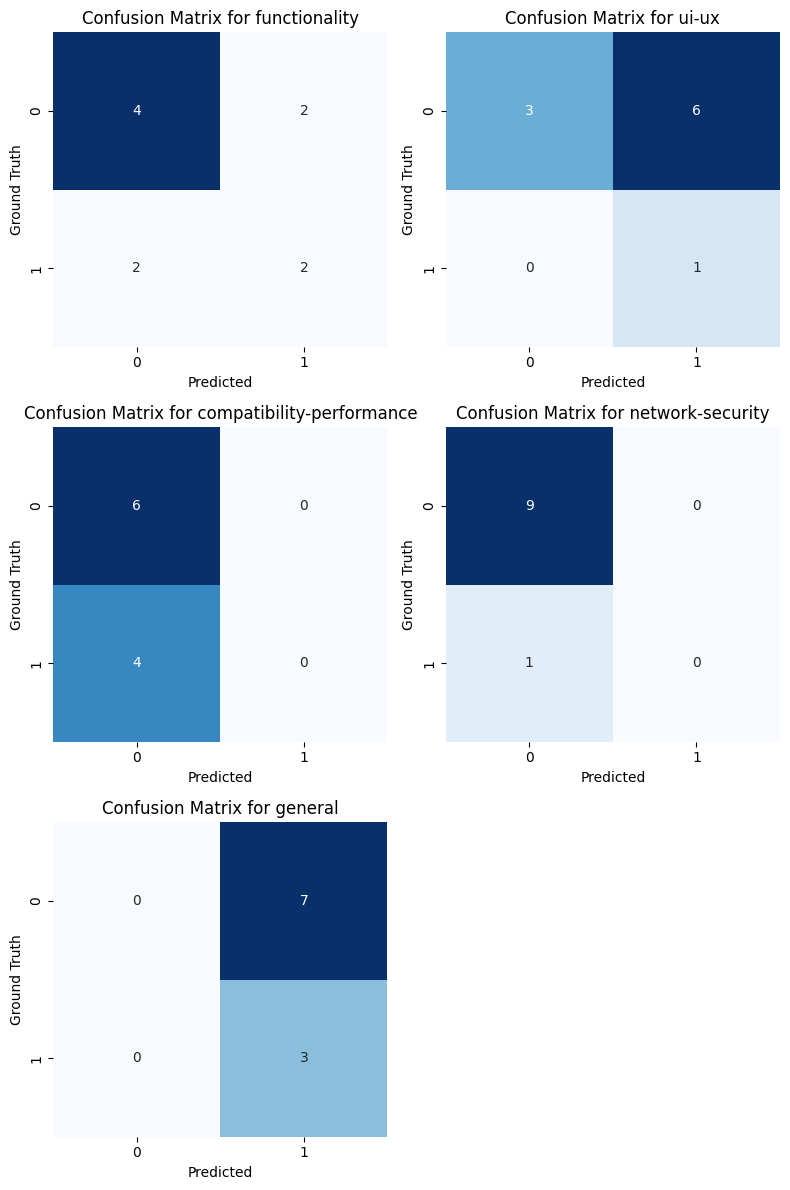

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.663324356079102     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.663324356079102}]

In [16]:
METRICS_PATH = 'metrics' if os.path.exists('metrics') else '/content/drive/MyDrive/Thesis/metrics'
os.environ['METRICS_PATH'] = METRICS_PATH
os.environ['VERSION'] = str(VERSION)
MODEL_NAME = 'CodeT5'
os.environ['MODEL_NAME'] = MODEL_NAME


torch_ds = CodeT5Dataset(encodings=encoded_samples, decodings=encoded_labels, class_labels=labels)
loader = DataLoader(torch_ds, batch_size=1, num_workers=14)

trainer = plTrainer()
trainer.test(model=model, dataloaders=loader)

## Compute Metrics

**ROUGE (Recall-Oriented understudy for Gisting Evaluation**
- A metric for evaluation text generation/sumamrization models.
- It measures the overlap between machine generated text (prediction) and its human generated corresponding text (reference)\ 
- [0,1] { close to 0: poor similarity, close to 1: better similarity}
- n-gram: seq of n words

Variations
- ROUGE-N : μετράει το σύνολο της επικάλυψης *[πόσες φορές εμφανίζετε στο παραγώμενο κείμενο]* το n-gram μεταξύ των προβλέψεων και του πραγματικού κειμένου

- ROUGE-N_recall : num n gram matches / num of n-gram in reference
- $ROUGE-N-precision : nummber of n-gram matches / number of n gram in prediction
- ROUGE-L : Βασίζεται στο μάκρος του μεγαλύτερης κοινής υπό-ακολουθίας (Longest Common Sequence -LCS) . Υπολογίζει το μέτρο f-measure
    - ROUGE-L_recall : LCS / num words in reference
    - ROUGE-L_precision : LCS / num words in prediction

In [17]:
from modules.metrics import CodeRouge
import json

rouge = CodeRouge(['rouge7','rouge8','rouge9','rougeL','rougeLsum'])

rouge.compute(predictions=model.generated_codes, references=test_df['new_contents'].tolist())
rouge.calc_averages()

avgs_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/rouge.json"
all_path = f"{METRICS_PATH}/{MODEL_NAME}_v{VERSION}/avg_rouge.csv"
with open(avgs_path, 'a') as f:
    json.dump(rouge.avgs, f, indent=4)

all_scores = []
for r in rouge.rouge_types:
    all_scores += rouge.rouge_type_to_list(r)

metrics_df = pd.DataFrame(all_scores)

for m in ['precision','recall','fmeasure']:
    metrics_df[m] = round(metrics_df[m], 3)
metrics_df.to_csv(all_path, index=False)

## Model Comparisons

### Bar Plots

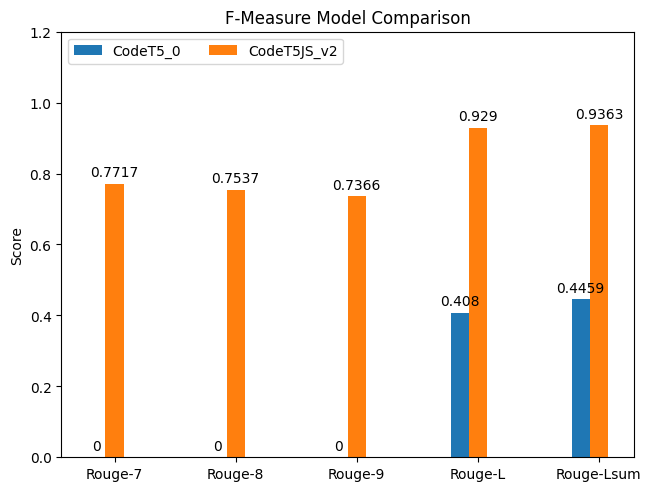

In [18]:
codebert_avgs = rouge.avgs

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)


plot_data = {
    f"{MODEL_NAME}_{VERSION}": (round(codebert_avgs['avg_rouge7'].fmeasure, 5), round(codebert_avgs['avg_rouge8'].fmeasure, 5), round(codebert_avgs['avg_rouge9'].fmeasure, 5), round(codebert_avgs['avg_rougeL'].fmeasure, 5), round(codebert_avgs['avg_rougeLsum'].fmeasure, 5)),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}

metric_types = ('Rouge-7', 'Rouge-8','Rouge-9', 'Rouge-L', 'Rouge-Lsum')
x = np.arange(len(metric_types))
width = 0.15
multiplier = 0

fix, ax = plt.subplots(layout='constrained')


for model, values in plot_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=model)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Score')
ax.set_title('F-Measure Model Comparison')
ax.set_xticks(x + width, metric_types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.2)

plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
plt.show()

### Chart

<Axes: title={'center': 'F-Measure Model Comparison'}, ylabel='Score'>

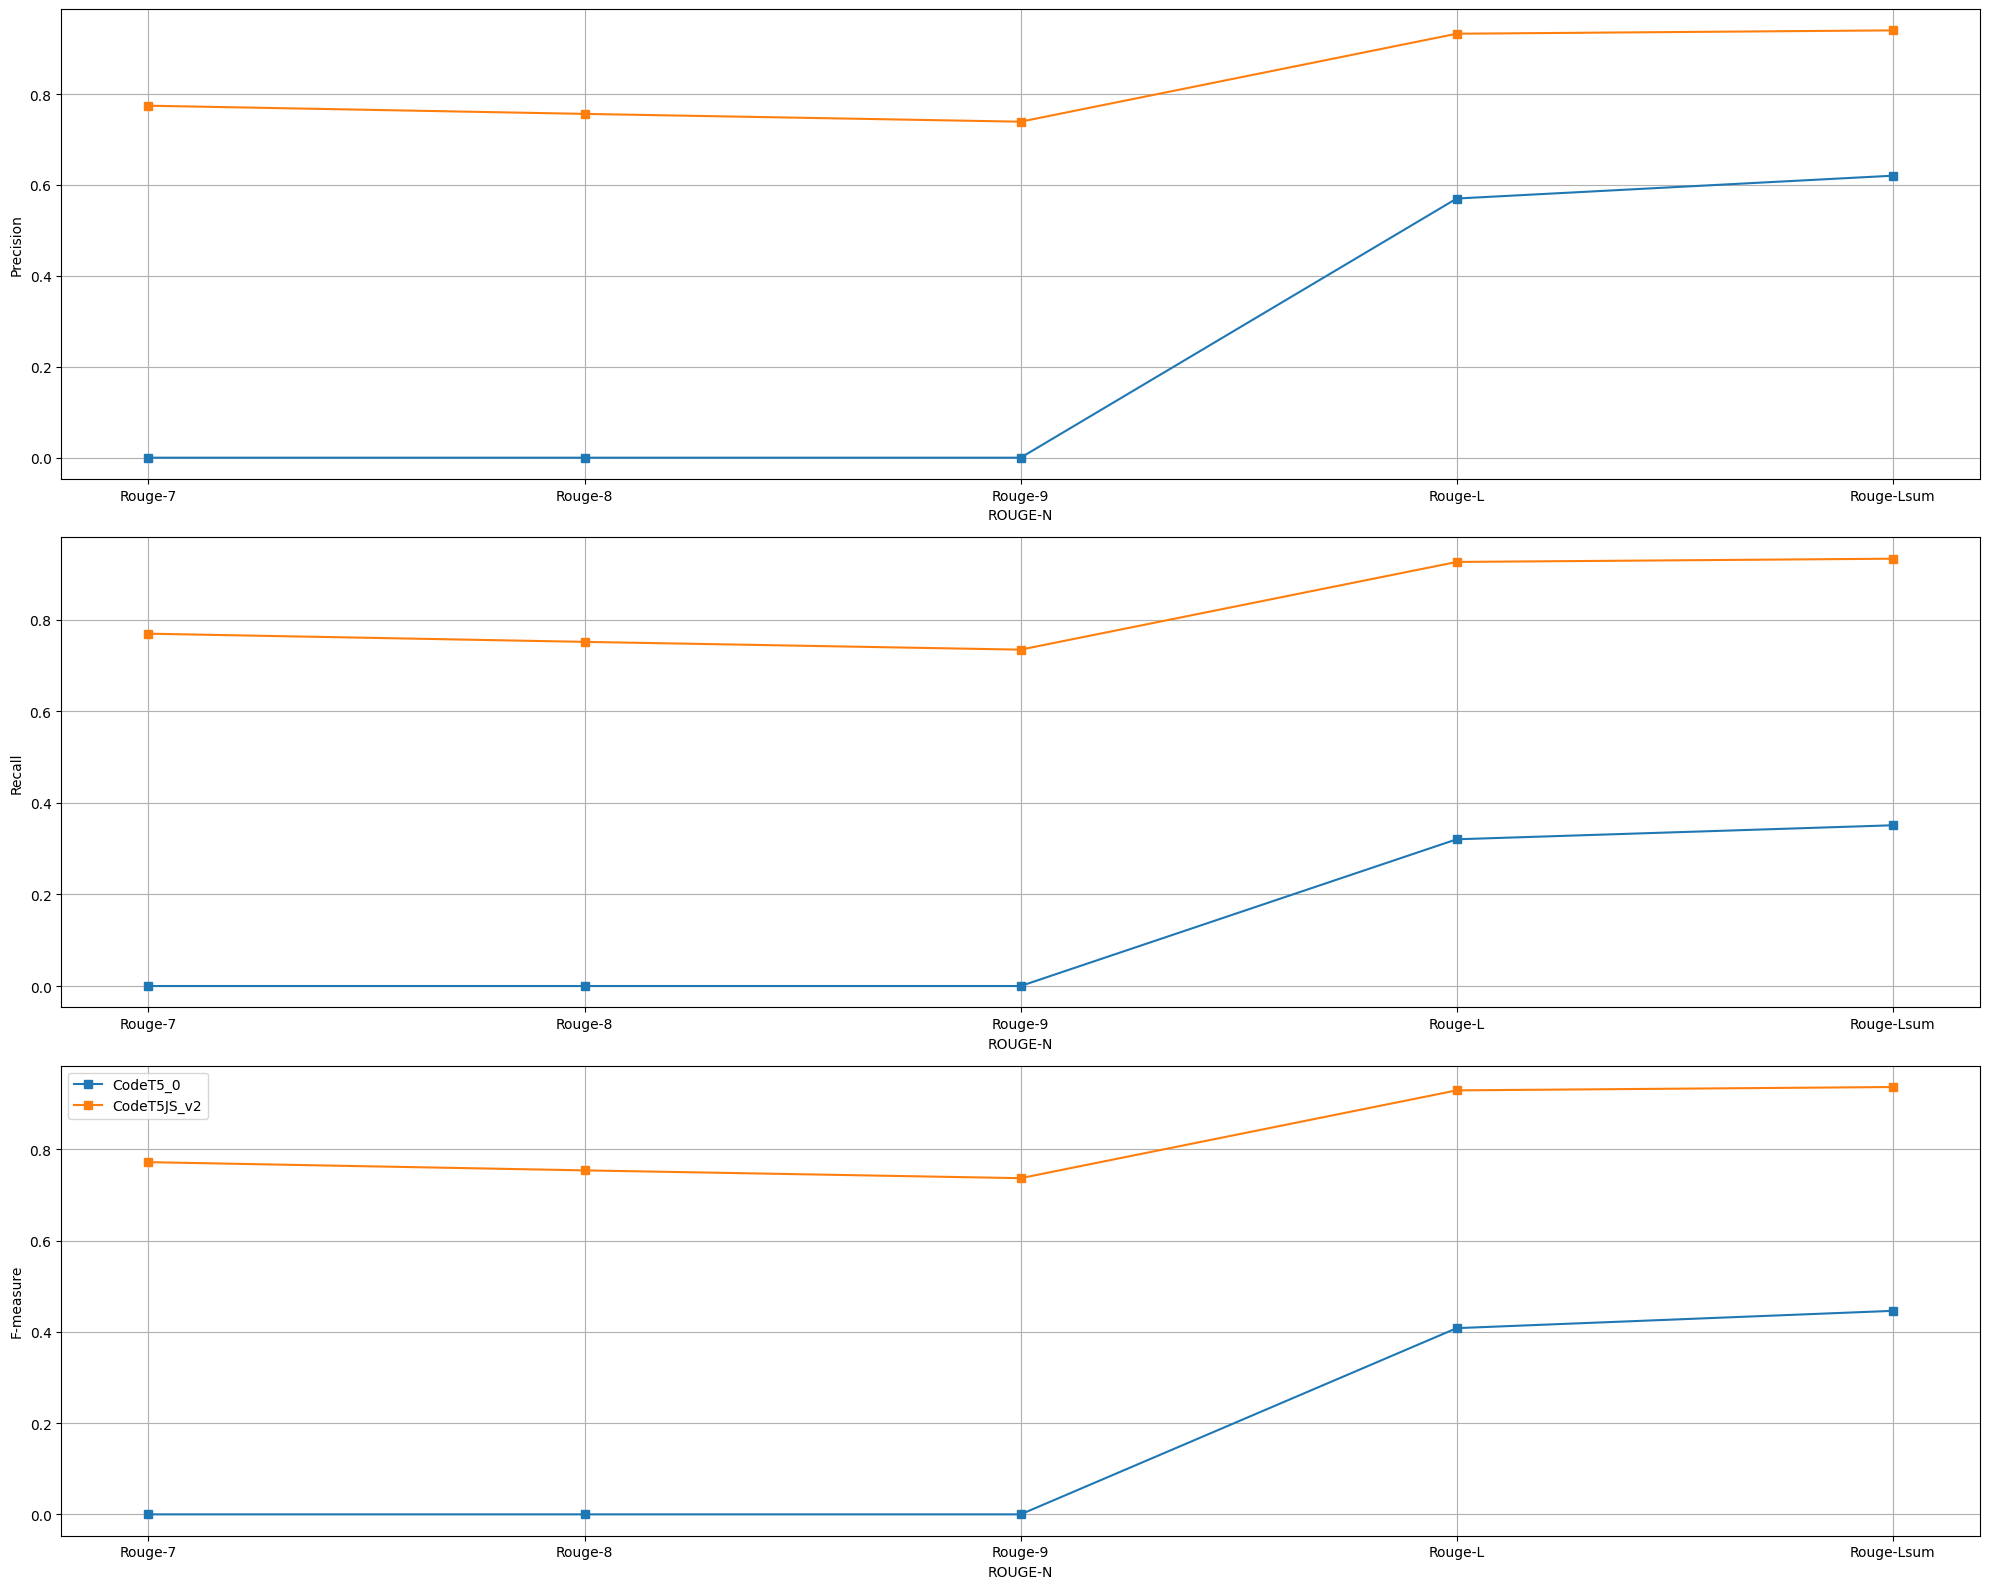

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np

codebert_avgs = rouge.avgs  # Assuming rouge is a library/function that provides average scores

comparison_model_path = input('Comparison model avg ROUGE-N metrics path: ')
comparison_model = comparison_model = comparison_model_path.split('/')[-2]
if not os.path.exists(comparison_model_path):
    raise RuntimeError('Metrics path does not exist.')

with open(comparison_model_path, 'r') as f:
    codet5_avgs = json.load(f)

# Define metric types (assuming same metrics for both models)
metric_types = ('Rouge-7', 'Rouge-8', 'Rouge-9', 'Rouge-L', 'Rouge-Lsum')

# Create a figure with 3 rows (subplots) and 1 column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 16))

# Data dictionaries for each metric (assuming data structure from rouge)
precision_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].precision, codebert_avgs['avg_rouge8'].precision, codebert_avgs['avg_rouge9'].precision, codebert_avgs['avg_rougeL'].precision, codebert_avgs['avg_rougeLsum'].precision),
    comparison_model: (codet5_avgs['avg_rouge7'][0], codet5_avgs['avg_rouge8'][0], codet5_avgs['avg_rouge9'][0], codet5_avgs['avg_rougeL'][0], codet5_avgs['avg_rougeLsum'][0]),
}
recall_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].recall, codebert_avgs['avg_rouge8'].recall, codebert_avgs['avg_rouge9'].recall, codebert_avgs['avg_rougeL'].recall, codebert_avgs['avg_rougeLsum'].recall),
    comparison_model: (codet5_avgs['avg_rouge7'][1], codet5_avgs['avg_rouge8'][1], codet5_avgs['avg_rouge9'][1], codet5_avgs['avg_rougeL'][1], codet5_avgs['avg_rougeLsum'][1]),
}
f1_data = {
    f"{MODEL_NAME}_{VERSION}": (codebert_avgs['avg_rouge7'].fmeasure, codebert_avgs['avg_rouge8'].fmeasure, codebert_avgs['avg_rouge9'].fmeasure, codebert_avgs['avg_rougeL'].fmeasure, codebert_avgs['avg_rougeLsum'].fmeasure),
    comparison_model: (round(codet5_avgs['avg_rouge7'][2], 5), round(codet5_avgs['avg_rouge8'][2], 5), round(codet5_avgs['avg_rouge9'][2], 5), round(codet5_avgs['avg_rougeL'][2], 5), round(codet5_avgs['avg_rougeLsum'][2], 5)),
}


# Plot Precision (ax1)
for model, precision in precision_data.items():
    ax1.plot(metric_types, precision, label=model, marker='s')  # 's' for square marker
ax1.set_xlabel('ROUGE-N')
ax1.set_ylabel('Precision')
ax1.grid(True)

# Plot Recall (ax2)
for model, recall in recall_data.items():
    ax2.plot(metric_types, recall, label=model, marker='s')  # 'o' for circle marker
ax2.set_xlabel('ROUGE-N')
ax2.set_ylabel('Recall')
ax2.grid(True)

# Plot F1 Score (ax3)
for model, f1 in f1_data.items():
    ax3.plot(metric_types, f1, label=model, marker='s')
ax3.set_xlabel('ROUGE-N')
ax3.set_ylabel('F-measure')
ax3.grid(True)

plt.legend(loc='upper left')
plt.tight_layout()

# Save the entire figure as a single PNG
plt.savefig(f"{METRICS_PATH}/{MODEL_NAME}_{VERSION}_vs_{comparison_model}.png", dpi=300, bbox_inches='tight')
ax